In [76]:
import open3d as o3d
import time
import skvideo.io 
import skimage.io
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from pathlib import Path

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)

# Make Scikit-Video happy
np.float = np.float64
np.int = np.int_

# From
# https://medium.com/@nearlydaniel/assertion-of-arbitrary-array-shapes-in-python-3c96f6b7ccb4
from collections import defaultdict
def assert_shape(x, shape:list):
    """ ex: assert_shape(conv_input_array, [8, 3, None, None]) """
    assert len(x.shape) == len(shape), (x.shape, shape)
    for _a, _b in zip(x.shape, shape):
        if isinstance(_b, int):
            assert _a == _b, (x.shape, shape)

In [77]:
DATA_PATH = Path("data/desks")

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

In [79]:
def get_matches(image0, image1):
    image0 = torch.from_numpy(image0.transpose(2, 0, 1))
    image1 = torch.from_numpy(image1.transpose(2, 0, 1))

    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    return m_kpts0, m_kpts1

(1440, 1920, 3)


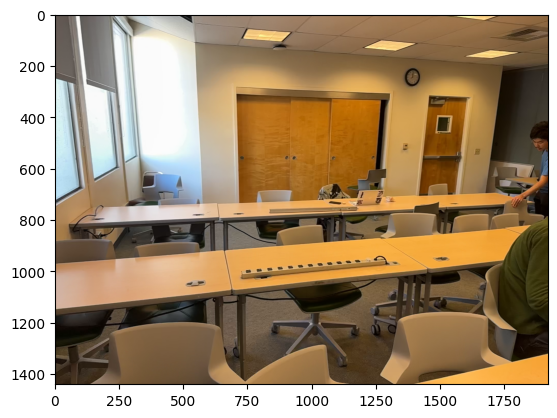

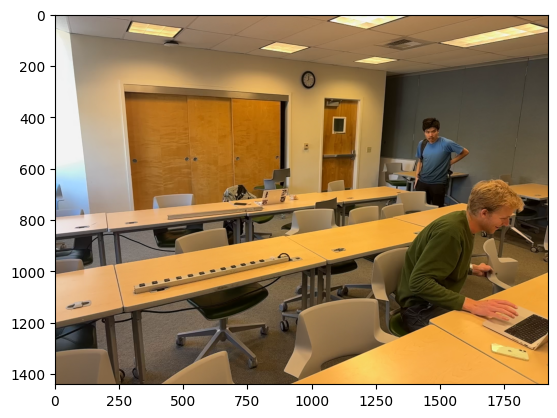

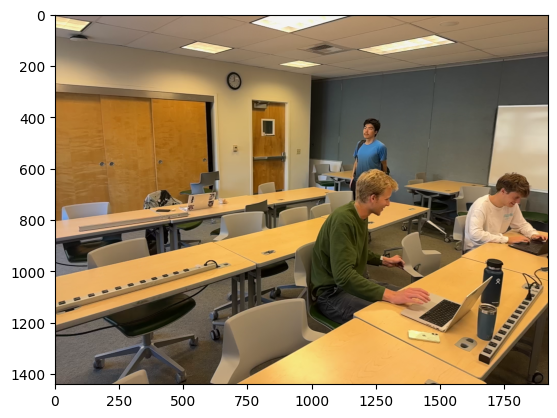

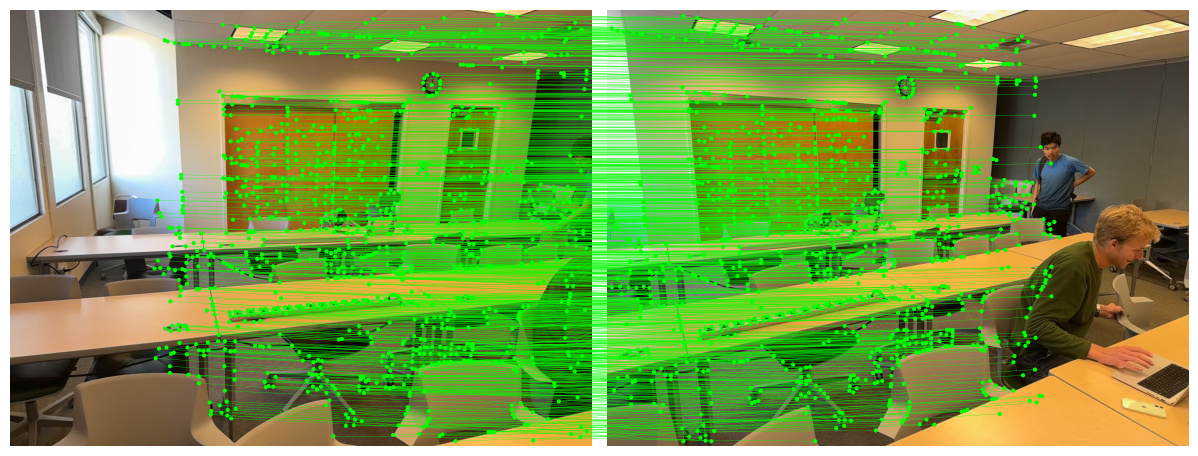

In [80]:
video_data = np.array(list(skvideo.io.vreader(str(DATA_PATH.joinpath("rgb.mp4")))))



video_data = (video_data.astype('float32') / 255.0)

rgb_image = video_data[0]

print(rgb_image.shape)

confidence_image = skimage.io.imread(sorted(list(DATA_PATH.glob("confidence/*.png")))[0])
confidence_image = skimage.transform.resize(confidence_image, rgb_image.shape[0:2], order=0)


# new_rgb_image = np.zeros((rgb_image.shape[0], rgb_image.shape[1], 3))

# new_rgb_image[..., 0] = (rgb_image == 0)
# new_rgb_image[..., 1] = (rgb_image == 1)
# new_rgb_image[..., 2] = (rgb_image == 2)

# rgb_image = new_rgb_image * 255
for i in range(len(video_data)):
    plt.imshow(video_data[i])
    plt.show()


np.array_equal(video_data[0], video_data[1])

m_kpts0, m_kpts1 =  get_matches(video_data[0], video_data[1])


axes = viz2d.plot_images([video_data[0], video_data[1]])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)

# kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
# viz2d.plot_images([image0, image1])
# viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

In [81]:
calibration_matrix = np.genfromtxt(DATA_PATH.joinpath("camera_matrix.csv"), delimiter=',')
calibration_matrix

array([[1.3355164e+03, 0.0000000e+00, 9.5817630e+02],
       [0.0000000e+00, 1.3355164e+03, 7.2457760e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

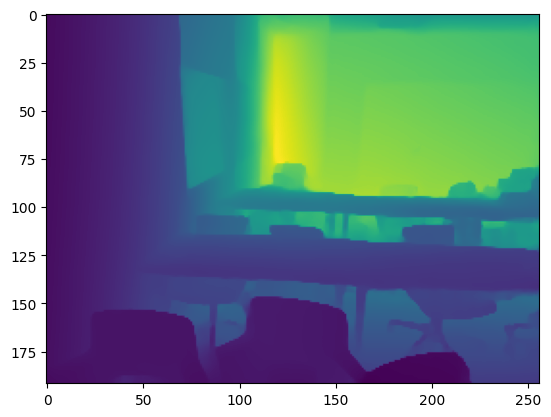

In [82]:
depth_image_paths = sorted(list(DATA_PATH.glob("depth/*.png")))

depth_images = [skimage.io.imread(path) for path in depth_image_paths]

plt.imshow(depth_images[0])

In [83]:
def points_2d_to_3d(points_homogenous_2d: np.array, depths: np.array, calibration_matrix: np.array):

    assert_shape(points_homogenous_2d, (None, 3))

    point_num = len(points_homogenous_2d)

    assert_shape(depths, (point_num, 1))
    assert_shape(calibration_matrix, (3,3))

    # Ray from Point in Image:
    # Ideas from https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
    # And https://stackoverflow.com/questions/68249598/how-to-calculate-the-ray-of-a-camera-with-the-help-of-the-camera-matrix

    camera_matrix_inv = np.linalg.inv(calibration_matrix)

    directions = np.matmul(camera_matrix_inv, points_homogenous_2d.T).T
    directions = directions / np.linalg.norm(directions)
    point_cloud = directions * depths # Add Depth info!


    assert_shape(point_cloud, (None, 3))

    return point_cloud[:, 0:3]

def image_to_point_cloud(calibration_matrix: np.array, rgb_image: np.array, depth_map: np.array) -> np.array:
    assert_shape(calibration_matrix, (3,3))

    assert_shape(rgb_image, (None, None, 3))
    height = rgb_image.shape[0]
    width = rgb_image.shape[1]

    assert_shape(depth_map, (None, None))


    xv, yv = np.meshgrid(np.arange(width), np.arange(height))
    all_pixels = np.stack([xv.ravel(), yv.ravel(), np.ones_like(xv).ravel()], axis=1)

    # Upscale depth to the same as our RGB image
    upscaled_depth_image = skimage.transform.resize(depth_map, rgb_image.shape[0:2], order=0)

    point_cloud = points_2d_to_3d(all_pixels, upscaled_depth_image.reshape(-1, 1), calibration_matrix)

    assert_shape(point_cloud, (None, 3))

    return point_cloud

In [84]:
def compute_euclidean_transform_ransac(image0, point_cloud0, image1, point_cloud1, matching_threshold=0.3, iterations=100)-> skimage.transform.EuclideanTransform:
    
    assert_shape(image0, (None, None, 3))
    
    image0_height = image0.shape[0]
    image0_width = image0.shape[1]
    assert_shape(point_cloud0, (image0_height * image0_width, 3))


    assert_shape(image1, (None, None, 3))

    image1_height = image1.shape[0]
    image1_width = image1.shape[1]

    assert_shape(point_cloud1, (image1_height * image1_width, 3))


    # Shape (None, 2), (None, 2)
    matched_keypoints0, matched_keypoints1 = get_matches(image0, image1)

    # Round to nearest pixel
    matched_keypoints0 = np.round(matched_keypoints0.numpy()).astype(int)
    matched_keypoints1 = np.round(matched_keypoints1.numpy()).astype(int)

    # Turn (x, y) from image coordinates into index into point cloud
    point_cloud0_indices = matched_keypoints0[:, 0] + matched_keypoints0[:, 1] * image0_width
    point_cloud1_indices = matched_keypoints1[:, 0] + matched_keypoints1[:, 1] * image1_width

    print(point_cloud0_indices[0:10])

    # Get the 3D points for the matched keypoints
    matched_point_cloud0 = point_cloud0[point_cloud0_indices]
    matched_point_cloud1 = point_cloud1[point_cloud1_indices]


    best_model = None
    best_inlier_count = 0

    for _ in range(iterations):

        # Get 3 random indices
        random_indices = np.random.choice(len(matched_point_cloud0), 3)

        model = skimage.transform.EuclideanTransform()
        model.estimate(matched_point_cloud0[random_indices], matched_point_cloud1[random_indices])

        transformed_points = model(matched_point_cloud0)

        # Get inliers under threshold
        error = np.sqrt(np.sum((transformed_points - matched_point_cloud1)**2, axis=1))

        inlier_count = np.count_nonzero(error < matching_threshold)

        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_model = model
    
    return best_model

    
compute_euclidean_transform_ransac(video_data[0], image_to_point_cloud(calibration_matrix, rgb_image, depth_images[0]), video_data[1], image_to_point_cloud(calibration_matrix, rgb_image, depth_images[1]))


[1275944 2003095 1355052 1237660 2349207 1279900 1575696 1258862 2389506
 2323823]


<EuclideanTransform(matrix=
    [[ 0.96536236,  0.055326  , -0.25497952, -0.0402869 ],
     [-0.05922696,  0.9982153 , -0.00764069,  0.03941315],
     [ 0.25410173,  0.02247769,  0.96691626,  0.01054325],
     [ 0.        ,  0.        ,  0.        ,  1.        ]]) at 0x7f168ba314e0>

In [85]:
def add_point_cloud_to_viz(point_cloud, rgb_image, vis):
    colors = rgb_image.reshape(-1,3)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    vis.add_geometry(pcd)

In [86]:
point_cloud0 = image_to_point_cloud(calibration_matrix, video_data[0], depth_images[0])

point_cloud1 = image_to_point_cloud(calibration_matrix, video_data[1], depth_images[1])

model = compute_euclidean_transform_ransac(video_data[0], point_cloud0, video_data[1], point_cloud1, matching_threshold=0.1, iterations=1000)

point_cloud0 = model(point_cloud0)


# print(point_cloud.shape)


# create visualizer and window.
vis = o3d.visualization.Visualizer()
vis.create_window(height=480, width=640)

add_point_cloud_to_viz(point_cloud0[], video_data[0], vis)
add_point_cloud_to_viz(point_cloud1, video_data[1], vis)

# run non-blocking visualization. 
# To exit, press 'q' or click the 'x' of the window.
keep_running = True
while keep_running:
    keep_running = vis.poll_events()
    vis.update_renderer()

vis.destroy_window()

[1275944 2003095 1355052 1237660 2349207 1279900 1575696 1258862 2389506
 2323823]


KeyboardInterrupt: 